In this task, you should train Inception V3 with pytorch using transfer learning to classify CIFAR10 dataset.

# Load the dataset

Load the CIFAR10 dataset bellow. You can use either `torchvision.datasets.CIFAR10` or `sklearn.datasets.fetch_openml()` or any other way to load the dataset.

In [1]:
import torch
from torchvision import datasets
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision import models
import os
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import re
import torch.nn.functional as F

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
transform_compose = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((299, 299)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

cifar_dataset = datasets.CIFAR10(root='dataset', train=True, download=True, transform=transform_compose)
train_size = int(0.9 * len(cifar_dataset))
val_size = len(cifar_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(cifar_dataset, (train_size, val_size))

test_dataset = datasets.CIFAR10(root='dataset', train=False, download=True, transform=transform_compose)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting dataset/cifar-10-python.tar.gz to dataset
Files already downloaded and verified


# Get Inception V3

Instantiate Inception V3 model (pretrained on imagenet) from `torchvision`'s model zoo.

In [4]:
model = models.inception_v3(pretrained=True).to(device)
model

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

# Modify for CIFAR10

Imagenet has 1000 classes, but CIFAR10 has 10. So, the decider layers of the model must be changed so that we can use the model for CIFAR10. Therefore, adapt `net.fc` and `net.AuxLogits.fc` with CIFAR10.

In [5]:
model.fc = nn.Linear(2048, 10).to(device)
model.AuxLogits.fc = nn.Linear(768, 10).to(device)

# Freeze the convolutional part

In order to apply transfer learning, freeze all layers except the deciders. Freezing consist of disabling optimization by disabling grad calculation. Also in batch normalization layers, updating mooving average and variance must be disabled. Note that you must later filter out the frozen parameter for optimizer.

In [6]:
class freeze:
    def __init__(self, train) -> None:
        self.old_train = train

    def __call__(self, *args, **kwargs) -> None:
        pass

In [7]:
import re 

frozen_names = []
for x, p in model.named_parameters():
    if re.compile(r'(?!^.*fc\..*$)(^.*$)').fullmatch(x):
        p.requires_grad = False
        frozen_names.append(x[:x.rfind('.')])

for x, m in model.named_modules():
    if (x in frozen_names):
      if isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)):
        m.eval()
        m.train = freeze(m.train)

# Instantiate the optimizer

Create the optimizer filtering out freezed parameters.

In [8]:
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model

Write your train/validation loop bellow. Then train the model until it converges. Feel free to add extra cells.

In [15]:
num_epochs = 25

train_loss_arr, val_loss_arr = [], []
train_accuracy, val_accuracy = [], [] 
for epoch in range(num_epochs):
    train_loss, val_loss = 0, 0

    model.train()

    epoch_all_train = 0
    epoch_true_train = 0
    epoch_accuracy = 0
    epoch_all_val = 0
    epoch_true_val = 0
    n = 0 
    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        p, s = model(x)
        n += len(x)

        batch_loss = criterion(p, y) + 0.2 * criterion(s, y)
        batch_size = p.shape[0]
        train_loss += float(batch_loss.item() * batch_size)
        

        predictions = p.argmax(-1)
        epoch_all_train += len(predictions)
        epoch_true_train += int((predictions == y).sum())

        batch_loss.backward()

        optimizer.step()
    
    epoch_true_train *= 100.0 / n

  
    n = 0
    model.eval()            
    with torch.no_grad():
      for i, (x, y) in enumerate(val_loader):
        x = x.to(device)
        y = y.to(device)
        p = model(x)
        n += len(x)

        batch_loss = criterion(p, y)
        batch_size = p.shape[0]
        val_loss += float(batch_loss.item() * batch_size)

        predictions = p.argmax(-1)
        epoch_all_val += len(predictions)
        epoch_true_val += int((predictions == y).sum())

    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    epoch_true_val *= 100.0 / n

    train_loss_arr.append(train_loss)
    val_loss_arr.append(val_loss)
    train_accuracy.append(epoch_true_train)
    val_accuracy.append(epoch_true_val)

    print(f"[Epoch {epoch}]\t"
        f"Train Loss: {train_loss:.4f}\t"
        f"Validation Loss: {val_loss:.4f}\t"
        f"Train Accuracy: {epoch_true_train:.2f}\t"
        f"Validation Accuracy: {epoch_true_val:.2f}")

[Epoch 0]	Train Loss: 1.8609	Validation Loss: 1.0842	Train Accuracy: 54.41	Validation Accuracy: 71.64
[Epoch 1]	Train Loss: 1.1793	Validation Loss: 0.8592	Train Accuracy: 70.47	Validation Accuracy: 74.36
[Epoch 2]	Train Loss: 1.0121	Validation Loss: 0.7728	Train Accuracy: 72.82	Validation Accuracy: 75.90
[Epoch 3]	Train Loss: 0.9351	Validation Loss: 0.7252	Train Accuracy: 74.00	Validation Accuracy: 76.62
[Epoch 4]	Train Loss: 0.8894	Validation Loss: 0.6951	Train Accuracy: 74.72	Validation Accuracy: 77.46
[Epoch 5]	Train Loss: 0.8594	Validation Loss: 0.6722	Train Accuracy: 75.57	Validation Accuracy: 77.62
[Epoch 6]	Train Loss: 0.8339	Validation Loss: 0.6551	Train Accuracy: 75.99	Validation Accuracy: 78.38
[Epoch 7]	Train Loss: 0.8150	Validation Loss: 0.6434	Train Accuracy: 76.40	Validation Accuracy: 78.22
[Epoch 8]	Train Loss: 0.8035	Validation Loss: 0.6316	Train Accuracy: 76.52	Validation Accuracy: 78.70
[Epoch 9]	Train Loss: 0.7922	Validation Loss: 0.6235	Train Accuracy: 77.09	Validat

# Draw the training curves

Draw two diagrams for train and validat
ion, one showing loss of each epoch, and another showing accuracy of each epoch.

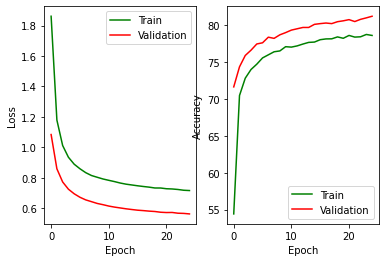

In [16]:
plt.subplot(1, 2, 1)

plt.plot(train_loss_arr,'green',label = 'Train')
plt.plot(val_loss_arr,'red',label = 'Validation')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.rcParams["figure.figsize"] = (20,15)


plt.subplot(1, 2, 2)

plt.plot(train_accuracy,'green',label = 'Train')
plt.plot(val_accuracy,'red',label = 'Validation')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.rcParams["figure.figsize"] = (20,15)


plt.show()

# Evaluate your model

Evaluate the best epoch's model (according to the validation accuracy) on the test set, and report the accuracy. Is your model overfitted?

In [18]:
model.eval()
accuracy = 0.0
total = 0.0
test_loss = 0
with torch.no_grad():
    for data in test_loader:
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      batch_loss = criterion(p, y)
      batch_size = p.shape[0]
      test_loss += float(batch_loss.item() * batch_size)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      accuracy += (predicted == labels).sum().item()

test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")
accuracy = (100 * accuracy / total)
print(f"accuracy: {accuracy:.2f}")

Test Loss: 0.0110
accuracy: 80.17


Our model performs perfect because we can see that the accuracy for the test set is good enough.

# Draw misclassified images

Draw 20 misclassified images from test set with expected and predicted labels.

In [19]:
predicted_labels = []

model.eval()
with torch.no_grad():
    for data in test_loader:
      x, labels = data
      images = x.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      predicted_labels.append(predicted)

In [30]:
import itertools
predicted_labels = list(itertools.chain.from_iterable(predicted_labels))

In [40]:
import numpy as np

labels = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

wrong_images = []
predicted_actual = []

indices = np.random.choice([i for i, (x, y) in enumerate(test_loader.dataset) if predicted_labels[i] != y], size=20)
for index in indices:
   wrong_images.append(test_loader.dataset[index][0].permute((1, 2, 0)))
   p = predicted_labels[i].item()
   l = test_loader.dataset[index][1]
   predicted_actual.append("actual: " + str(labels[l]) + "     prediction: "+ str(labels[p]))

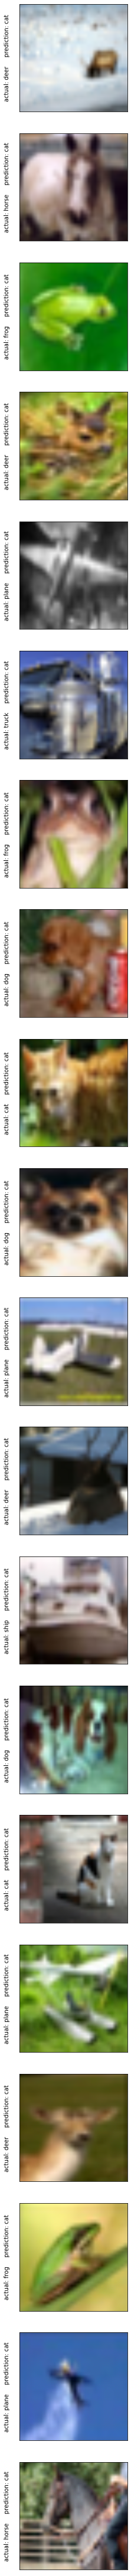

In [43]:
num_imgs = 20
fig, axs = plt.subplots(num_imgs, 1, figsize=(7, 80))
for i in range(num_imgs):
    x = wrong_images[i]
    axs[i].imshow((x - x.min()) / (x.max() - x.min()))
    axs[i].set_ylabel(predicted_actual[i] + "\n")
    for k in range(1):
        axs[i].set_yticks([])
        axs[i].set_xticks([])

# Plot the confusion matrix

Plot the confusion matrix for the test set.

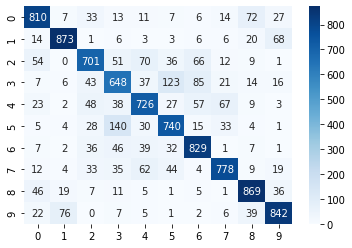

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

true_labels = [x for _, x in test_loader.dataset]
predicted = [int(x) for x in predicted_labels]
sns.heatmap(confusion_matrix(true_labels, predicted), cmap="Blues", annot=True, fmt='d')